In [1]:
import pandas as pd
import pickle
import os
import json
import re
from PIL import Image
import pprint
from scipy.stats import norm
prettyprint = pprint.PrettyPrinter(indent=4)

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [3]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")

from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

#from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
#BASE_DATA_PATH='../../data'
#BASE_IMAGES_PATH='../../images'
from covid19_pytoolbox import settings
settings.BASE_DATA_PATH='../../data'
settings.BASE_IMAGES_PATH='../../images'

from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.modeling.Rt import naive
from covid19_pytoolbox.utils import smape, padnan

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
alpha = 1.87
beta = 0.28

ALPHA=100.

In [5]:
local_imported = ISS.read_weekly_cases_from_local(datetime.now())
ISS.preprocess_cases(local_imported)
ISS.RSVD_smooth_data(local_imported, alpha, beta, difference_degree=6)

['total', 'imported']
total_deseason
info_cri:  1.9625857444954513
info_cri:  2.473229264752645
TIC R2: 0.9938246131422092
patterns: 1
(   -15.089913986512935,
    8.221529229165323e-28,
    19,
    499,
    {   '1%': -3.4435228622952065,
        '10%': -2.569864247011056,
        '5%': -2.867349510566146},
    -84.0379144680794)
new columns generated:
[   'total_deseason',
    'total_deseason_seasonality',
    'total_deseason_smoothed',
    'total_deseason_residuals',
    'total_deseason_relative_residuals',
    'total_deseason_smoothed_Rt']
imported_deseason
info_cri:  5.191080597881153
info_cri:  11.88962787846329
TIC R2: 0.844346091344966
patterns: 1
(   -17.754939020469596,
    3.357561672514259e-30,
    19,
    499,
    {   '1%': -3.4435228622952065,
        '10%': -2.569864247011056,
        '5%': -2.867349510566146},
    1233.5766340898203)
new columns generated:
[   'total_deseason',
    'total_deseason_seasonality',
    'total_deseason_smoothed',
    'total_deseason_residuals

In [6]:
local_imported['dayofyear'] = local_imported.data.dt.dayofyear.astype(float)

In [7]:
local_imported['imported_ratio_CI_min'], local_imported['imported_ratio_CI_max'] = norm.interval(
    0.95, 
    loc=local_imported.imported_ratio_avg14, 
    scale=local_imported.imported_ratio_std14
)

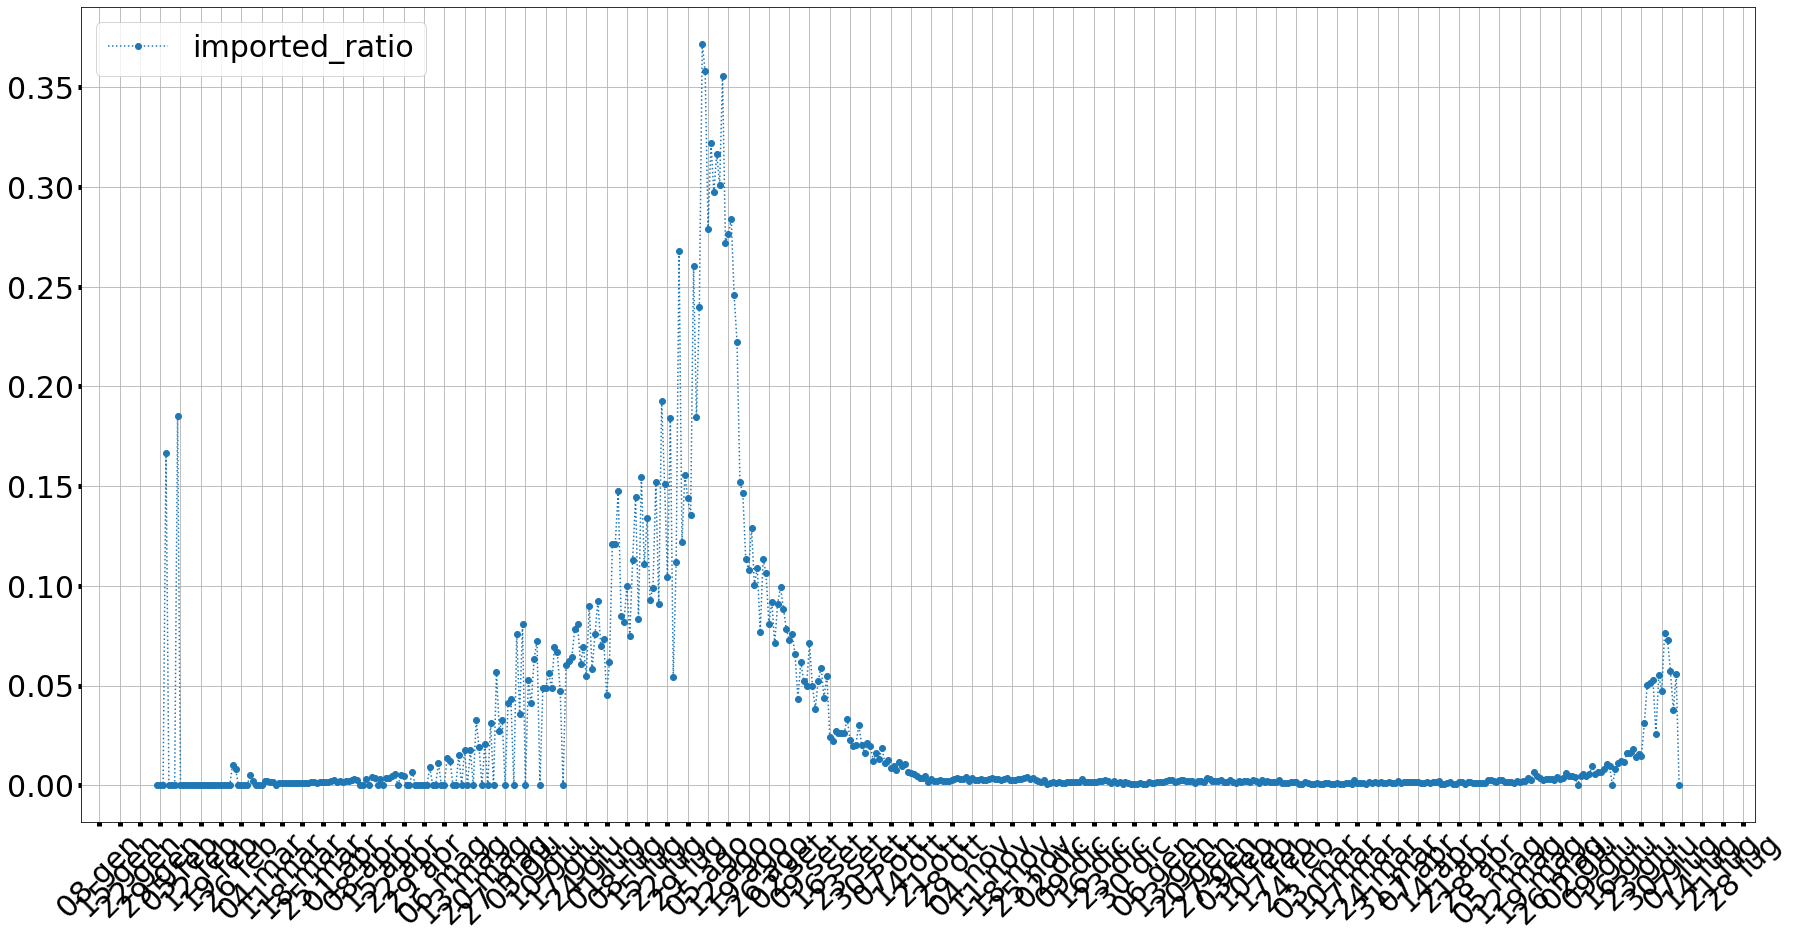

In [8]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'imported_ratio', 
    ],
    legend_loc="upper left"
)

In [9]:
local_imported["imported_ratio_deseason_smoothed"] = \
    local_imported.imported_deseason_smoothed/local_imported.total_deseason_smoothed

local_imported["imported_ratio_100_deseason_smoothed"] = \
    100*local_imported.imported_ratio_deseason_smoothed

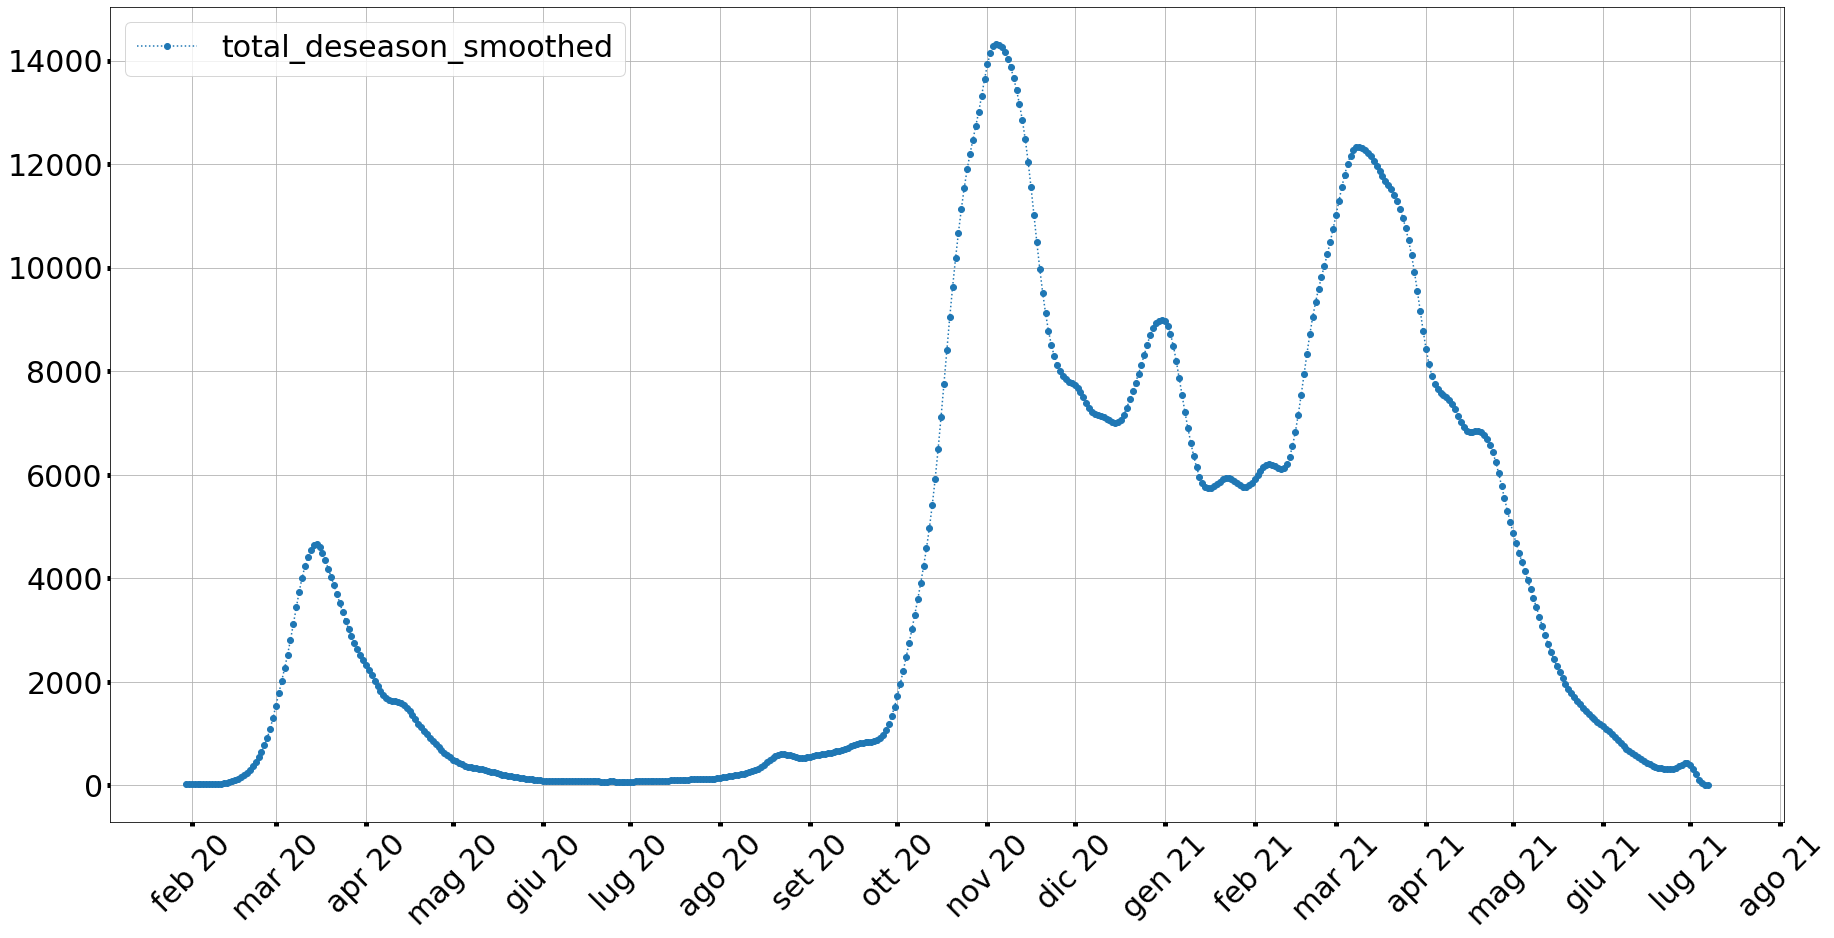

In [10]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'total_deseason_smoothed',
    ],
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),    
    legend_loc="upper left"
)

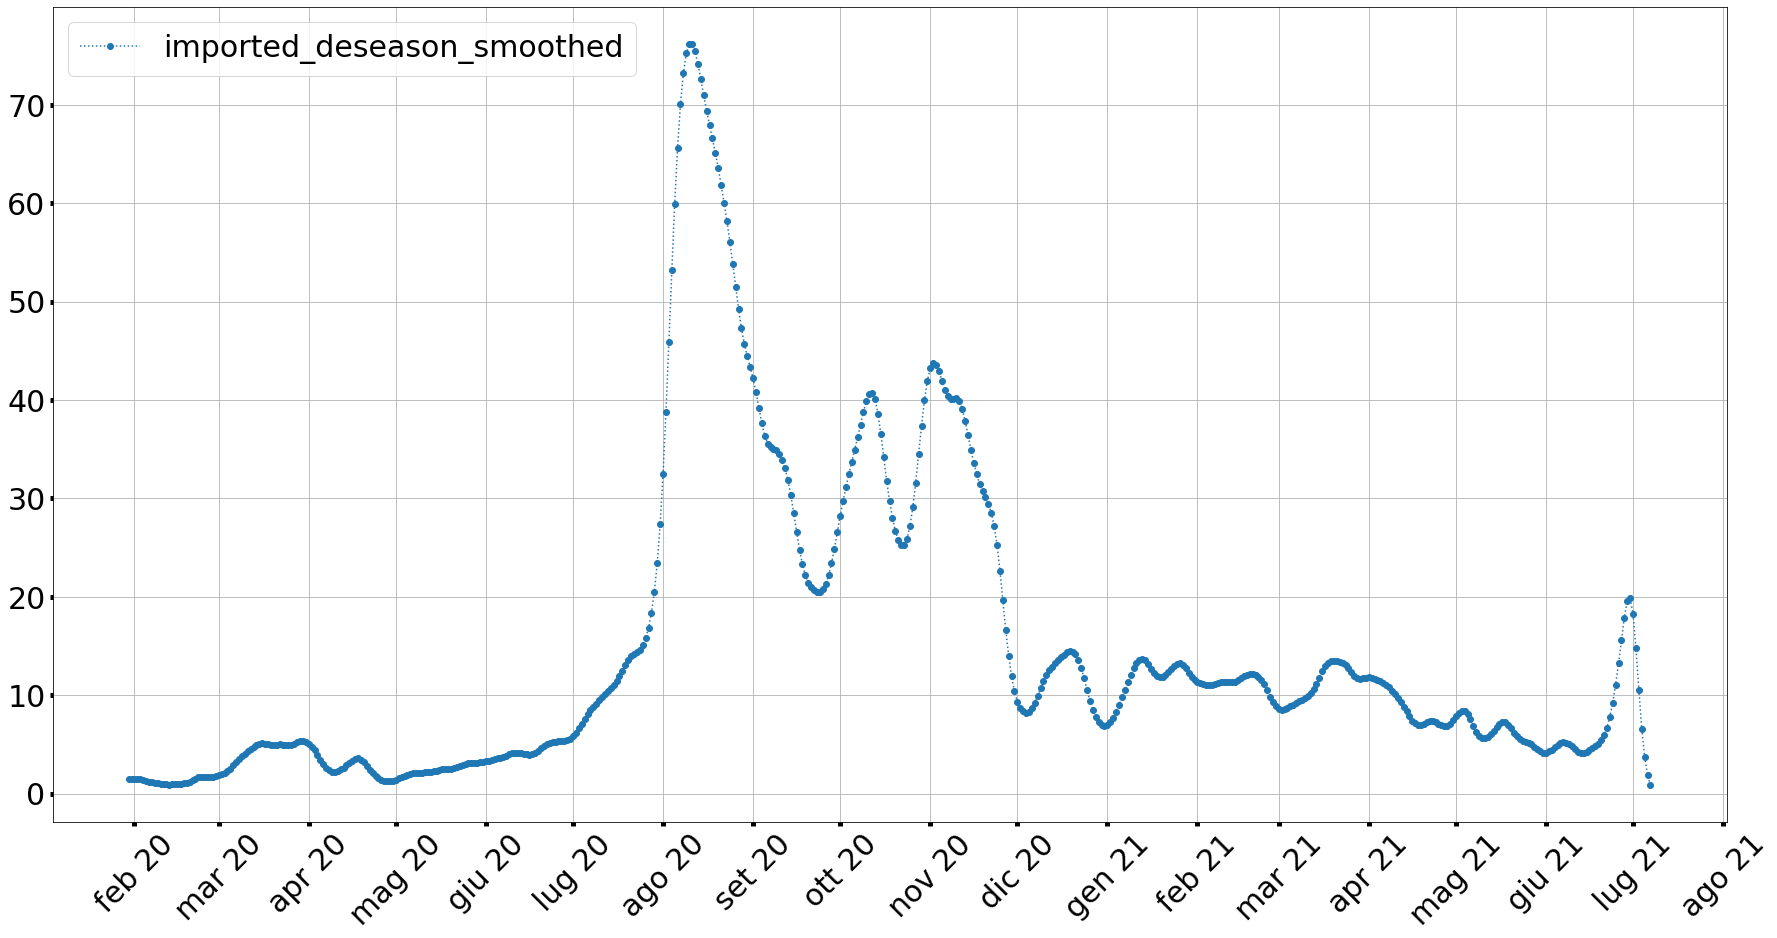

In [11]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'imported_deseason_smoothed',
    ],
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),    
    legend_loc="upper left"
)

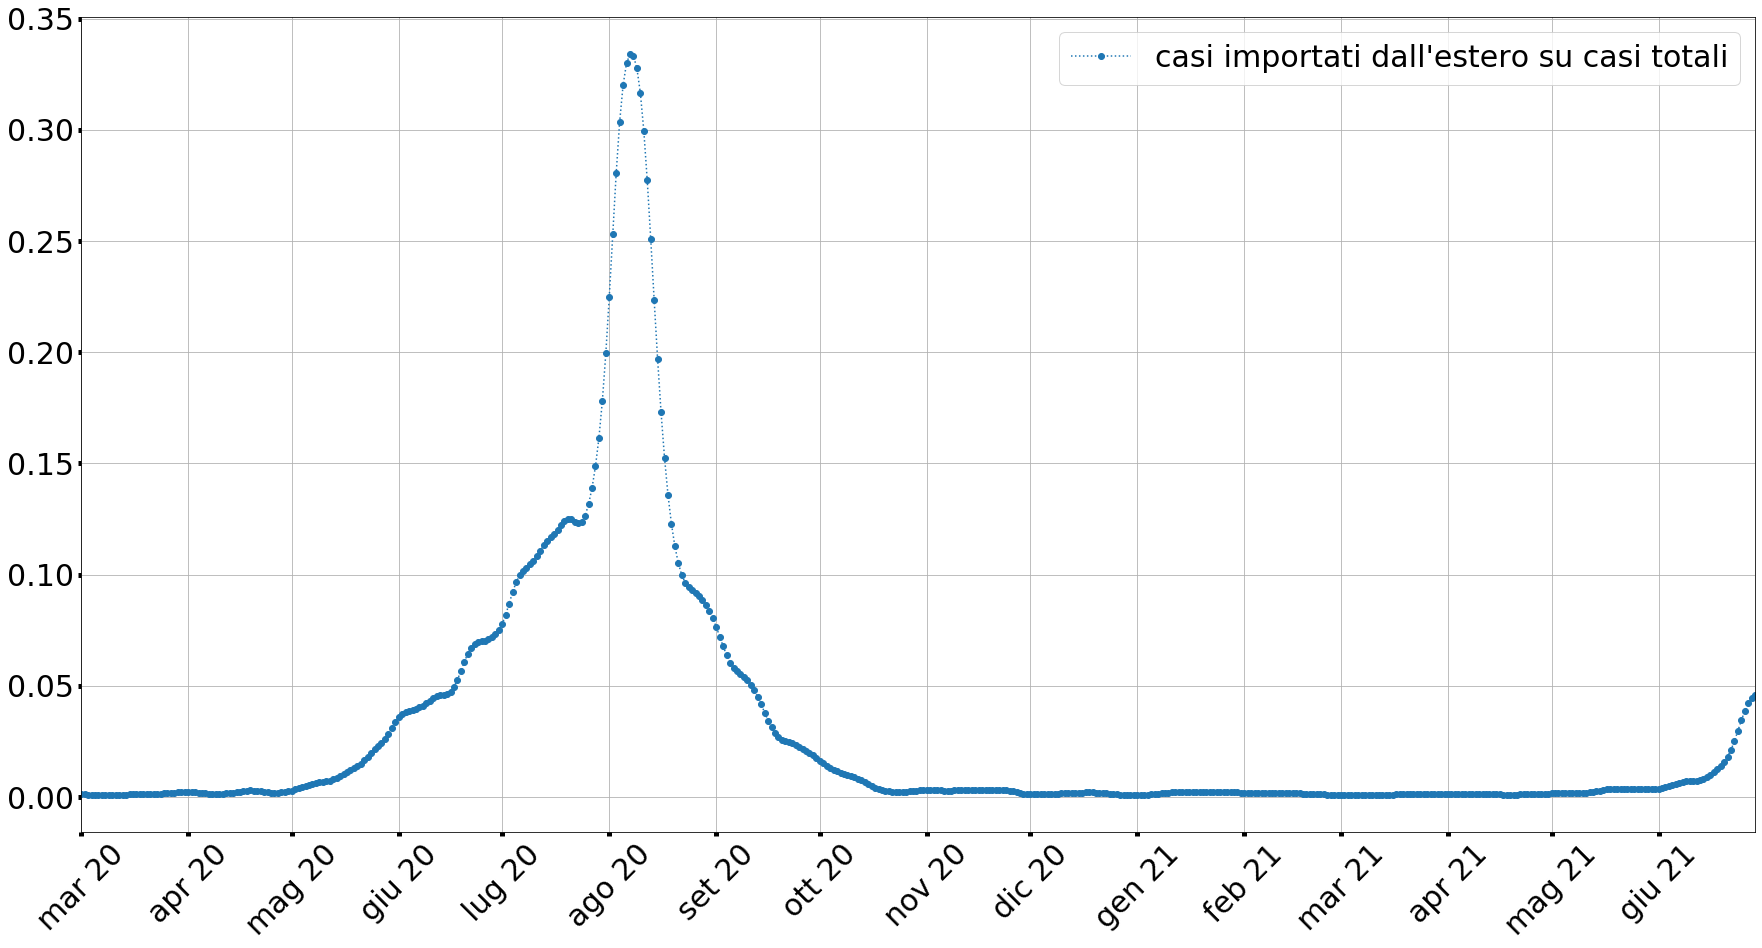

In [12]:
plotting.plot_series(
    data=[{
        'df': local_imported,
        'xfield': 'data',
        'yfields': [
            'imported_ratio_deseason_smoothed', 
        ],
        'labels':[
            'casi importati dall\'estero su casi totali',
        ]
    }],
    xlim=(datetime(2020,3,1), datetime(2021,6,29)),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

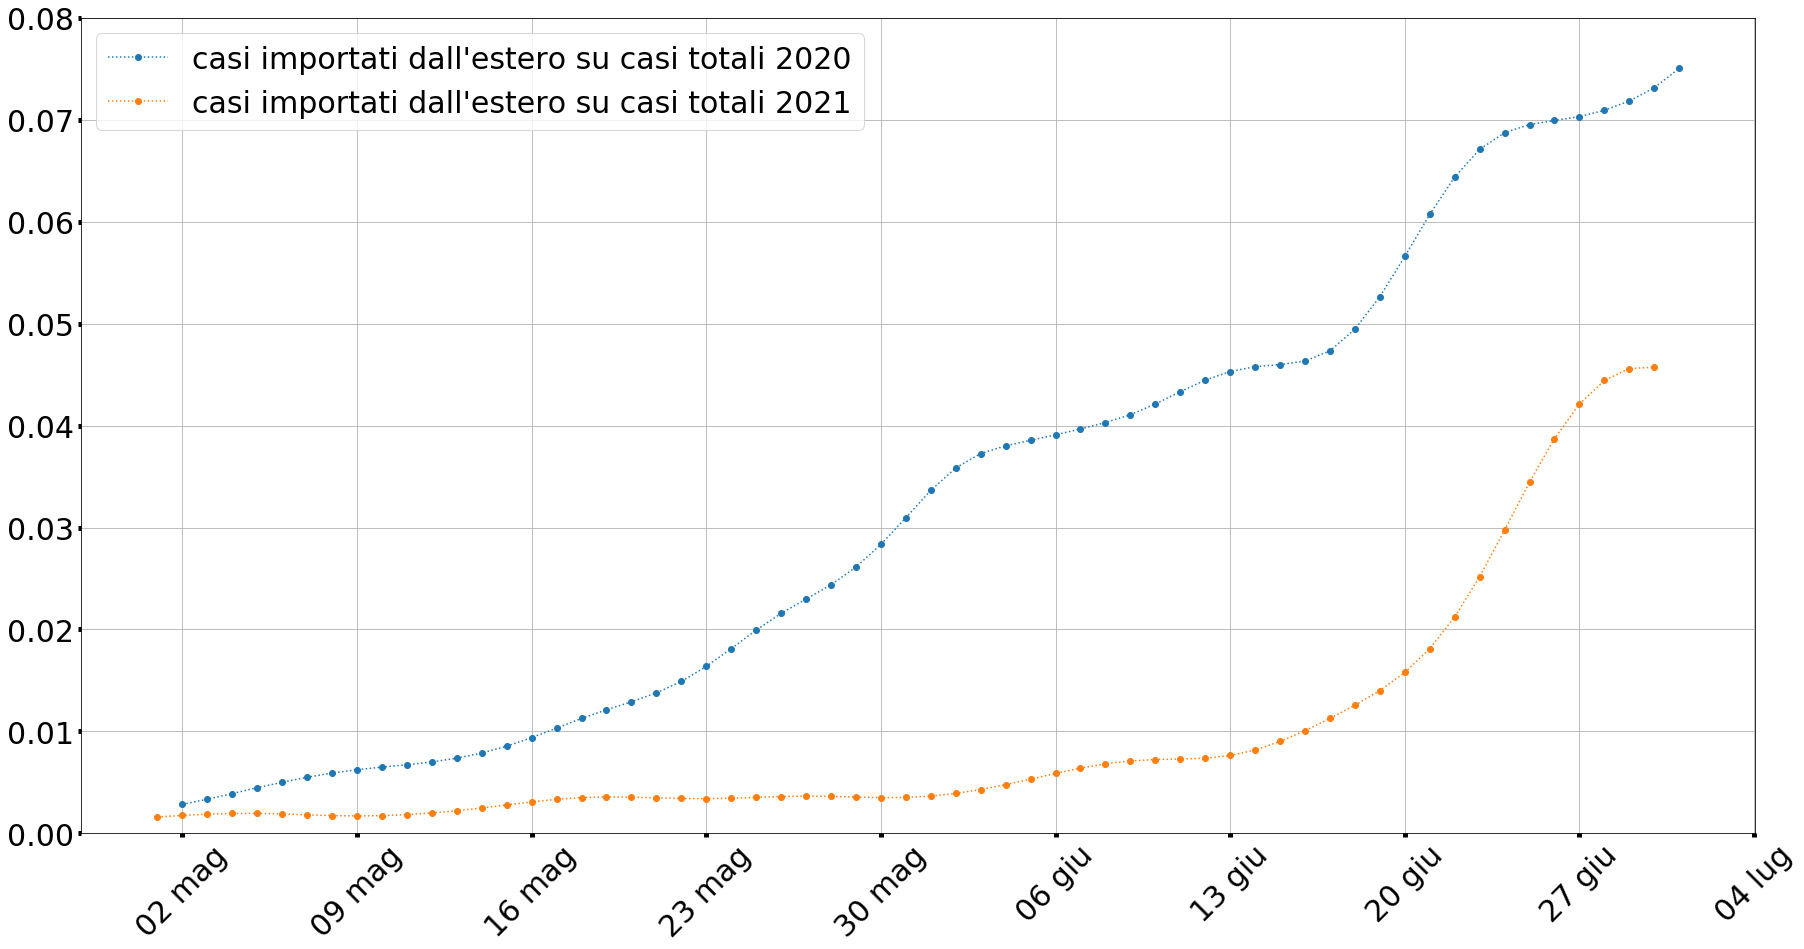

In [13]:
plotting.plot_series(
    data=[
        {
            'df': local_imported[(local_imported.data>="2020-05-01") & (local_imported.data<="2020-06-30")],
            'xfield': 'dayofyear',
            'yfields': [
                'imported_ratio_deseason_smoothed', 
            ],
            'labels':[
                'casi importati dall\'estero su casi totali 2020',
            ]
        },
        {
            'df': local_imported[(local_imported.data>="2021-05-01") & (local_imported.data<="2021-06-30")],
            'xfield': 'dayofyear',
            'yfields': [
                'imported_ratio_deseason_smoothed',                 
            ],
            'labels':[
                'casi importati dall\'estero su casi totali 2021',
            ]
        },        
    ],
    ylim=(0,0.08),
    #xlim=(datetime(2021,5,1), datetime(2021,6,29)),
    legend_loc="upper left",
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_zoom_2020_2021'),
    quality=40
)

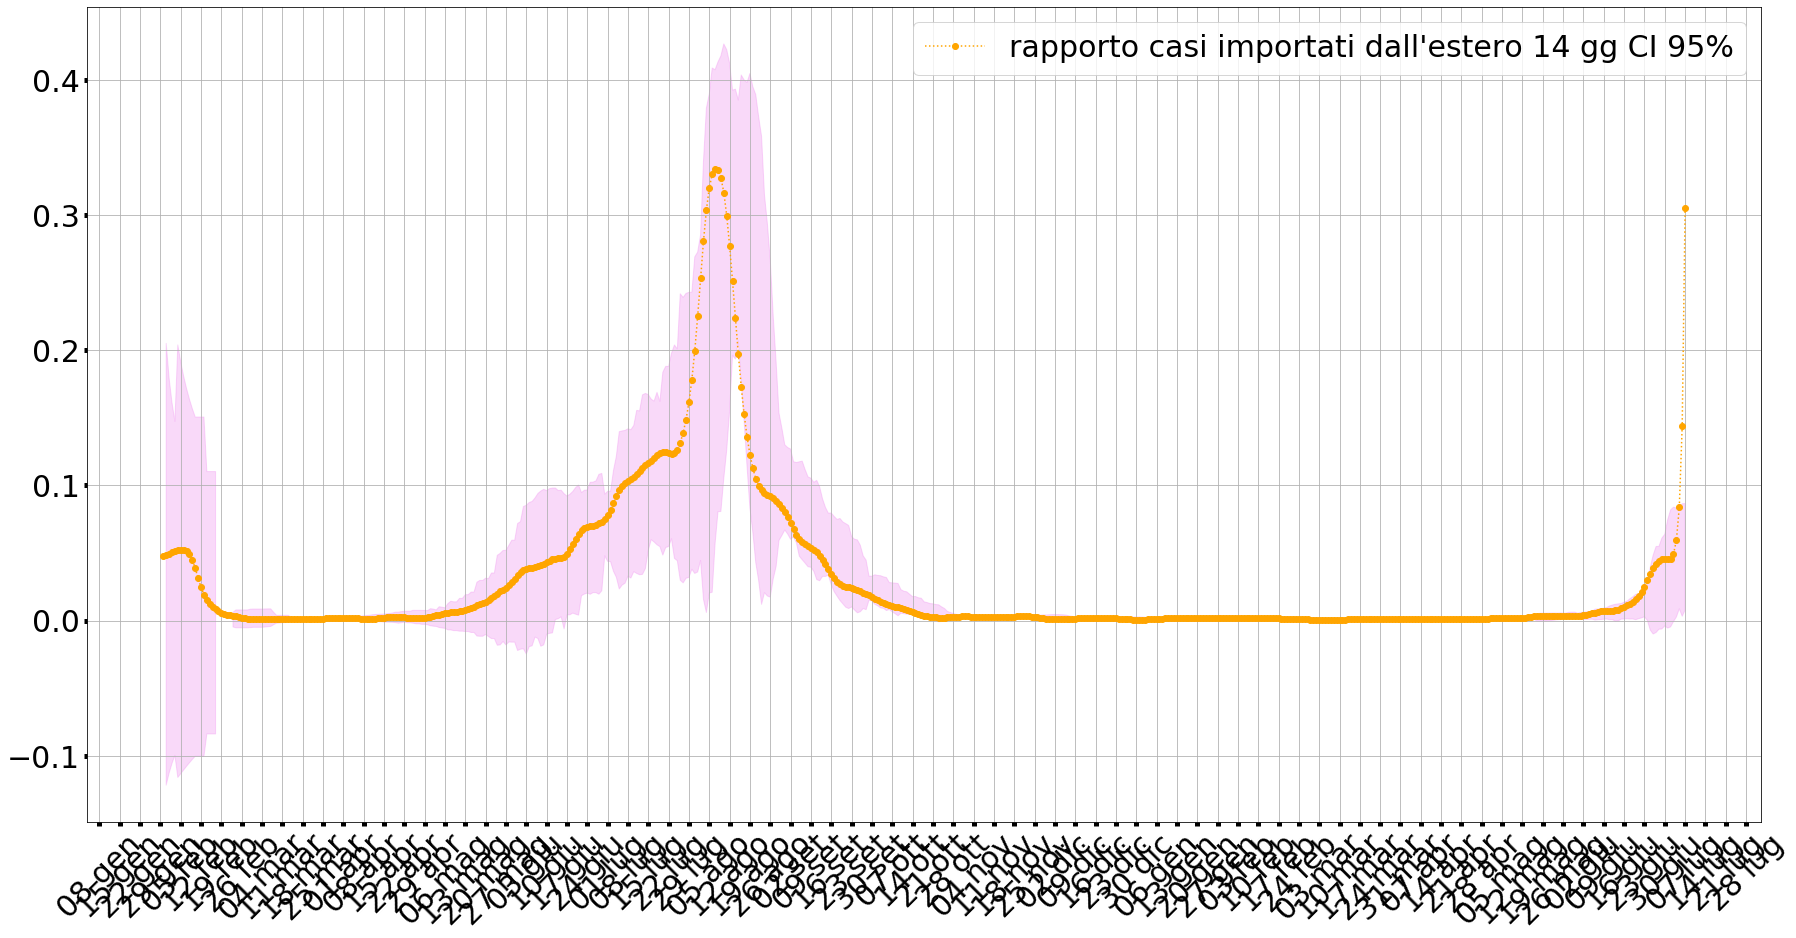

In [14]:
plotting.plot_series(
    data=[
        {
            'df': local_imported,
            'xfield': 'data',
            'yfields': [
                'imported_ratio_deseason_smoothed', 
            ],
            'fill_between': [
                'imported_ratio_CI_min',
                'imported_ratio_CI_max',
            ],
            'labels': [
                'rapporto casi importati dall\'estero 14 gg CI 95%',
            ],
            'colors':['orange']
        },        
    ],
    legend_loc="upper right"
)

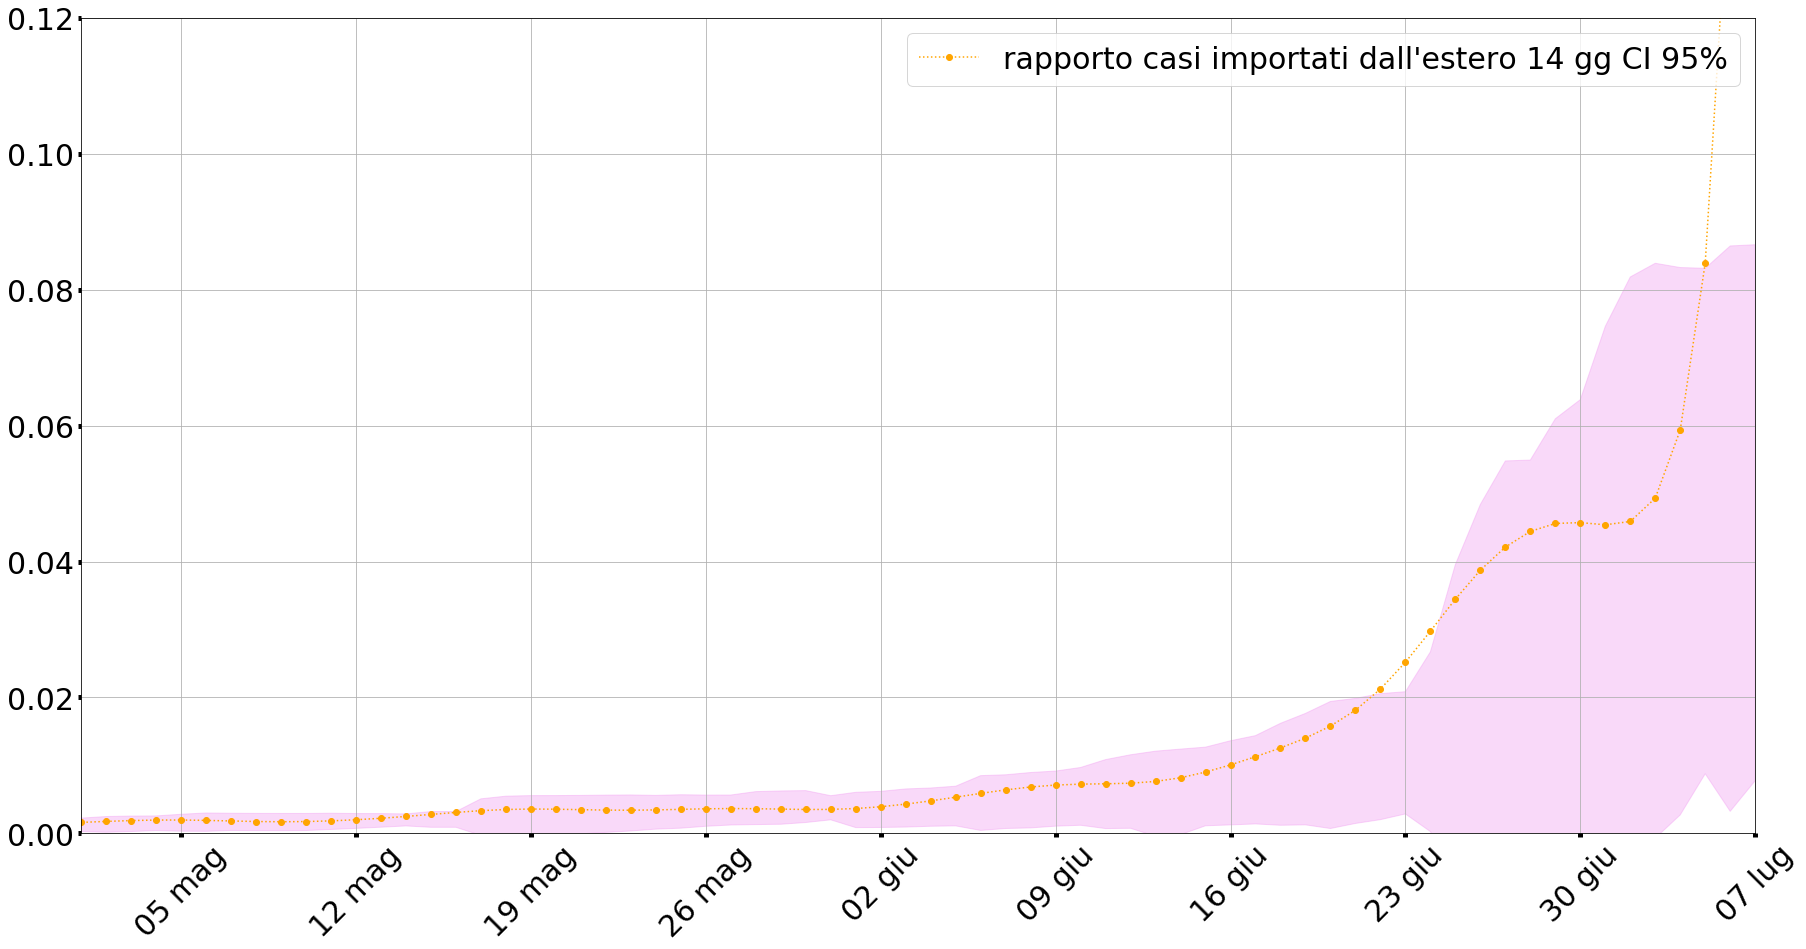

In [15]:
plotting.plot_series(
    data=[
        {
            'df': local_imported,
            'xfield': 'data',
            'yfields': [
                'imported_ratio_deseason_smoothed', 
            ],
            'fill_between': [
                'imported_ratio_CI_min',
                'imported_ratio_CI_max',
            ],
            'labels': [
                'rapporto casi importati dall\'estero 14 gg CI 95%',
            ],
            'colors':['orange']
        },        
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2021,5,1), datetime(2021,7,7)),
    ylim=(0,0.12),
    legend_loc="upper right"
)

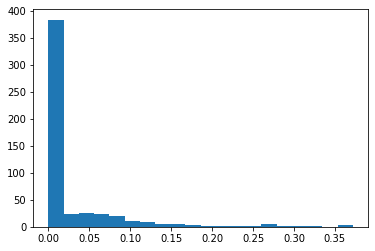

In [16]:
_ = plt.hist(local_imported.imported_ratio, bins=20)

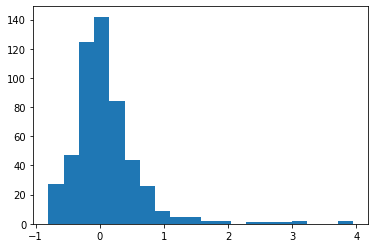

In [17]:
_=plt.hist(local_imported.imported_deseason_relative_residuals, bins=20)

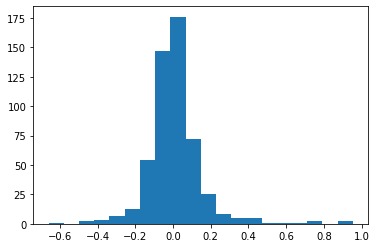

In [18]:
_=plt.hist(local_imported.total_deseason_relative_residuals, bins=20)

In [19]:
local_imported['imported_ratio_residuals'] = local_imported.imported_ratio - local_imported.imported_ratio_deseason_smoothed
local_imported['imported_ratio_rel_residuals'] = local_imported.imported_ratio_residuals /local_imported.imported_ratio

In [20]:
(local_imported.imported_ratio_rel_residuals==-np.inf).any()

True

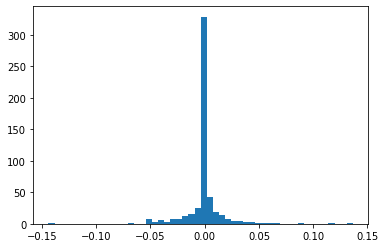

In [21]:
_ = plt.hist(local_imported.imported_ratio_residuals,bins=50)

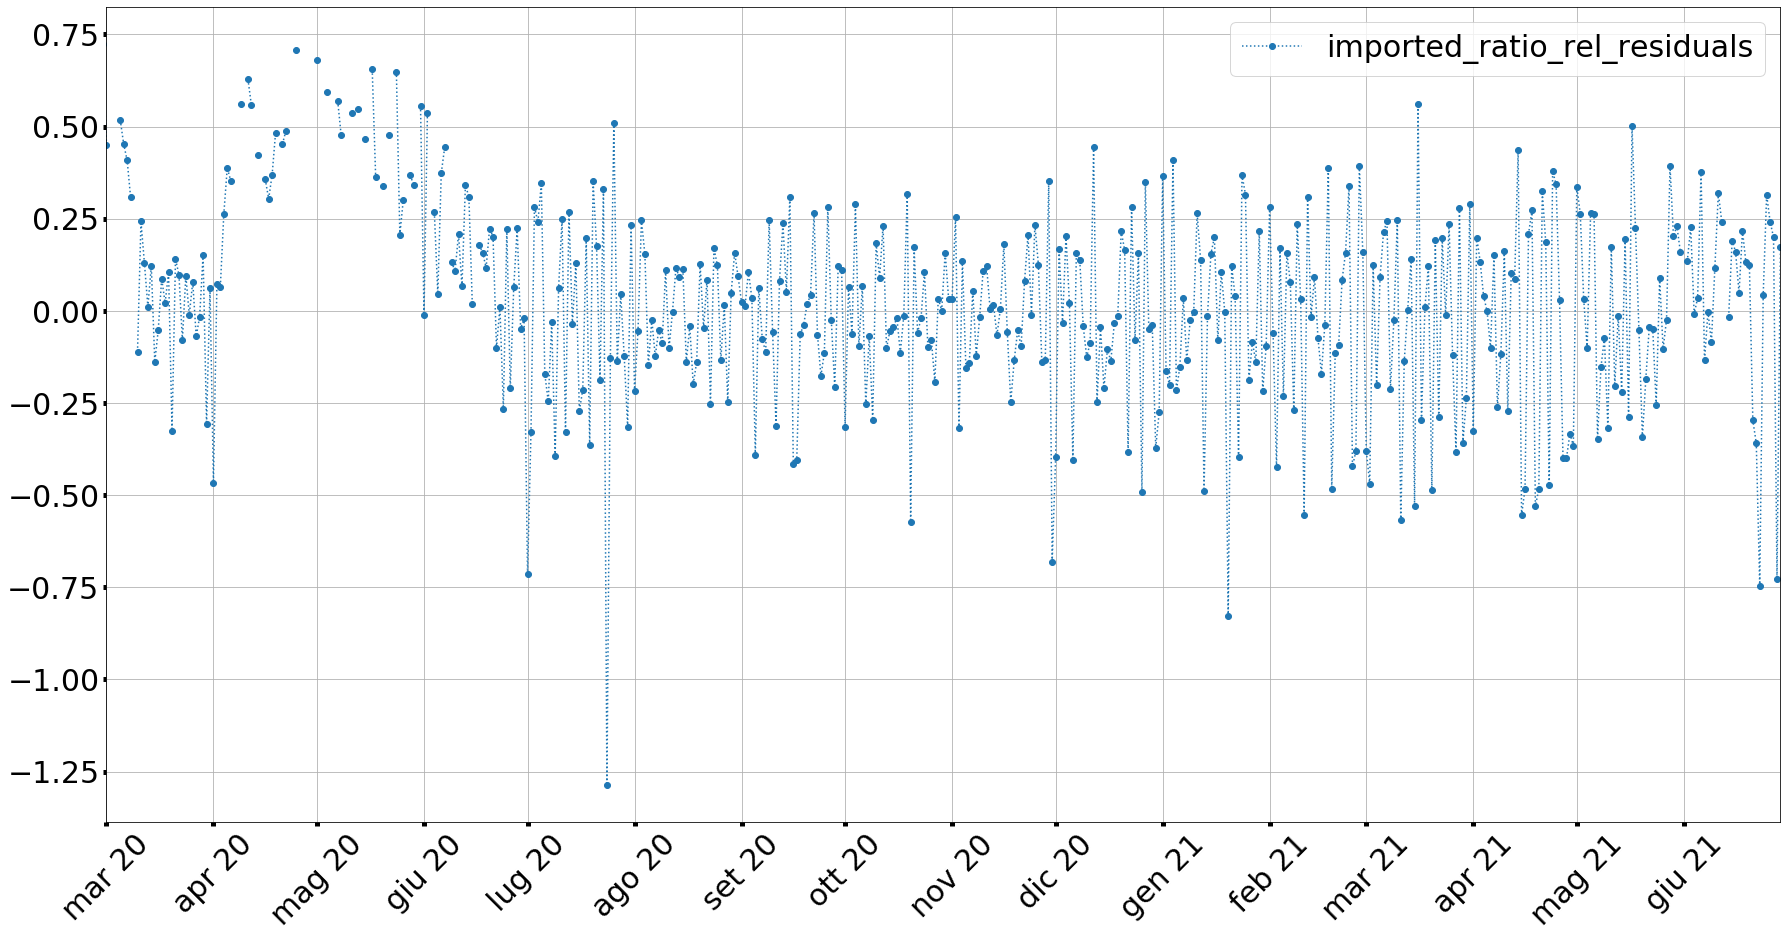

In [22]:
plotting.plot_series(
    data=[{
        'df': local_imported,
        'xfield': 'data',
        'yfields': [
            'imported_ratio_rel_residuals', 
        ],
    }],
    xlim=(datetime(2020,3,1), datetime(2021,6,29)),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

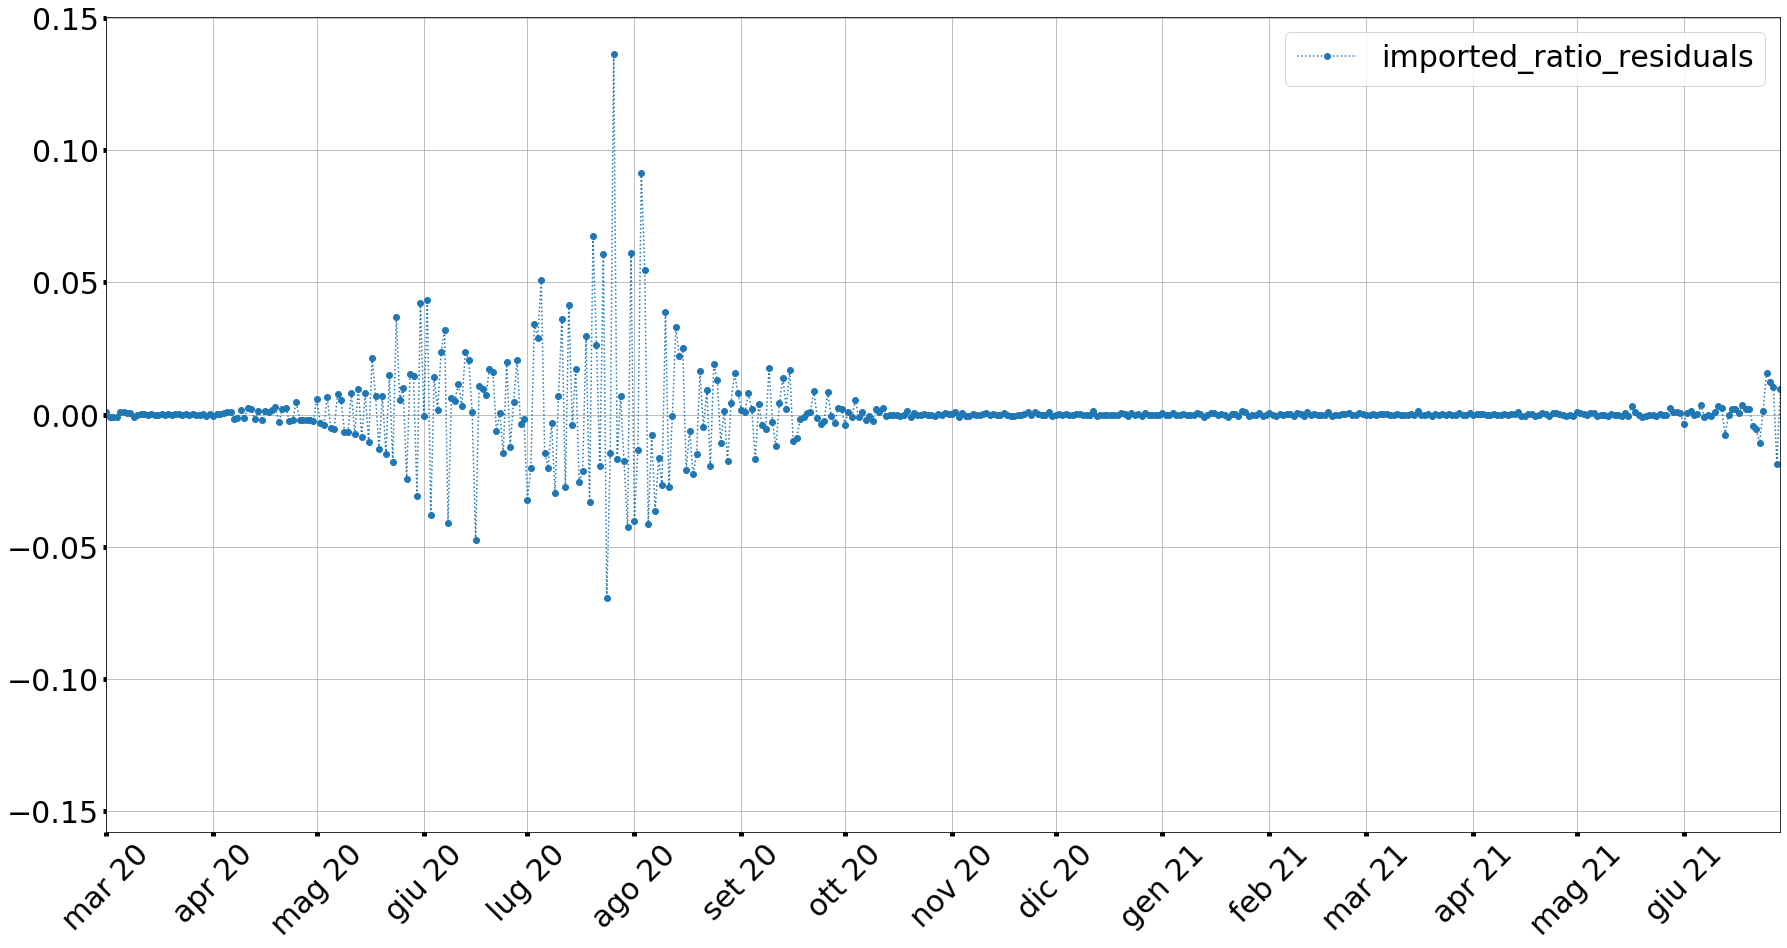

In [23]:
plotting.plot_series(
    data=[{
        'df': local_imported,
        'xfield': 'data',
        'yfields': [
            'imported_ratio_residuals', 
        ],
    }],
    xlim=(datetime(2020,3,1), datetime(2021,6,29)),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

In [30]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)

DPC_data = DPC.merge_ISS_weekly_cases(DPC_data, local_imported)
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)
DPC.compute_cases_corrected_by_imported(DPC_data)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.999997184658431
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999961517133329
deceduti_giornalieri_smoothed - TIC R2: 0.9999980190064596
nuovi_positivi_smoothed - TIC R2: 0.9999982275593299
nuovi_casi_da_sospetto_diagnostico_smooth

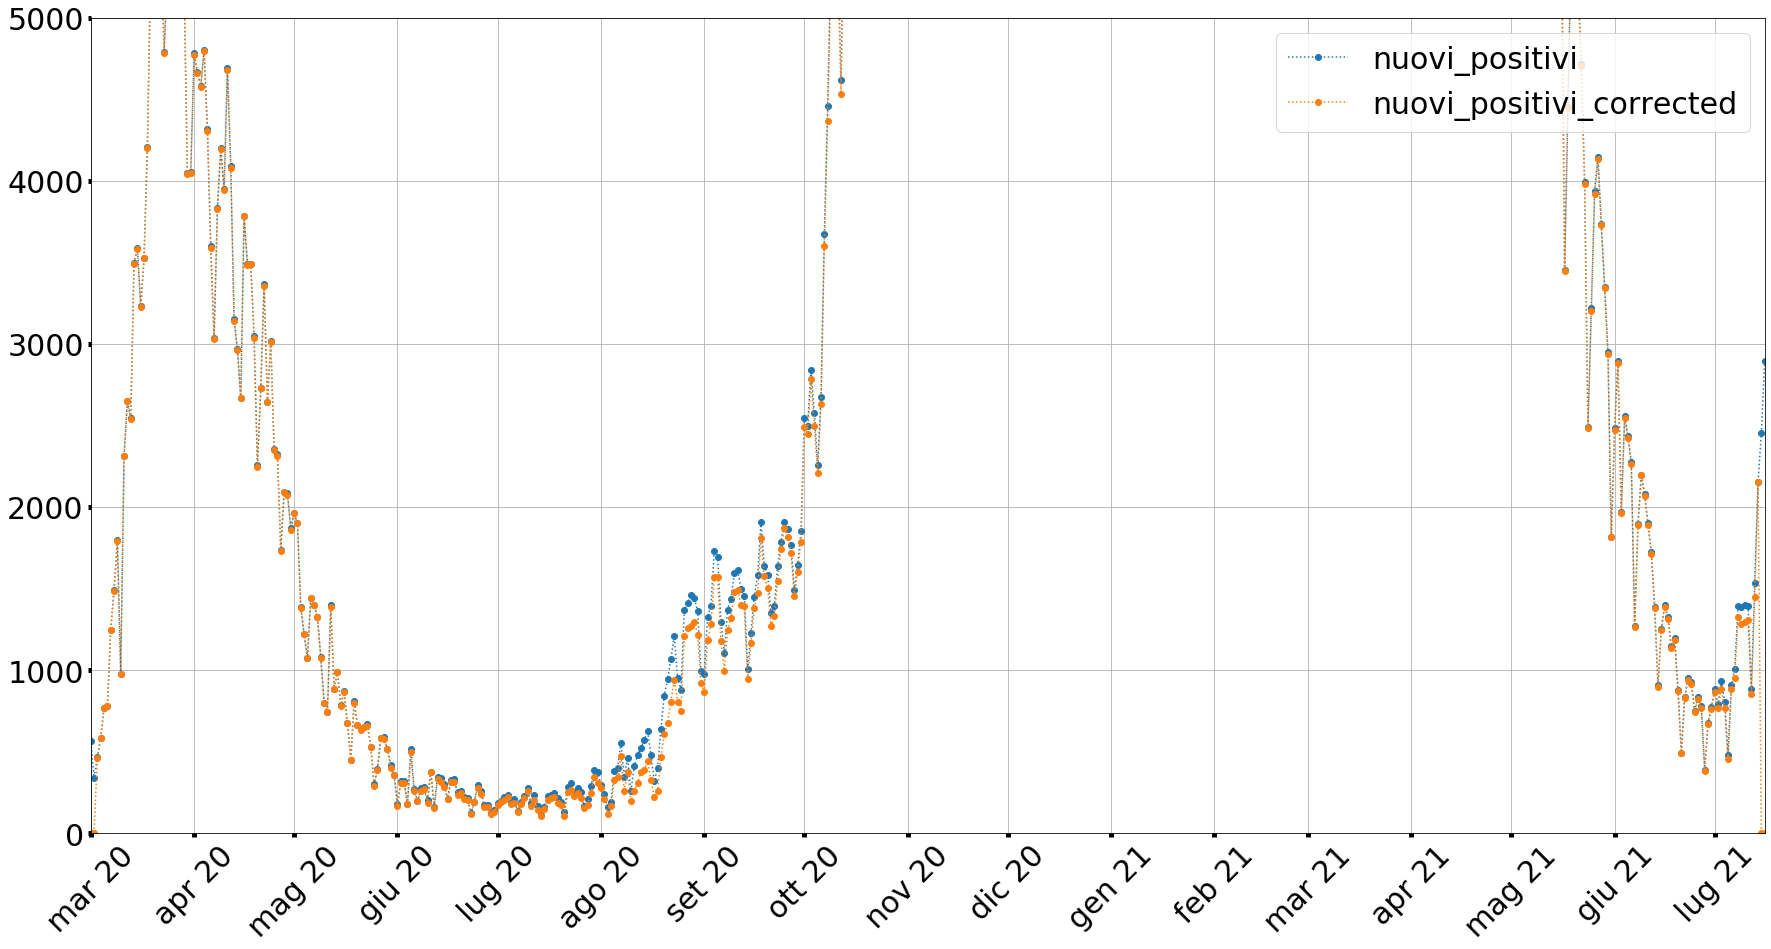

In [31]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            #'nuovi_positivi_deseason_smoothed_corrected', 
            #'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi',
            'nuovi_positivi_corrected'
        ],
    }],
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    ylim=(0,5000),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

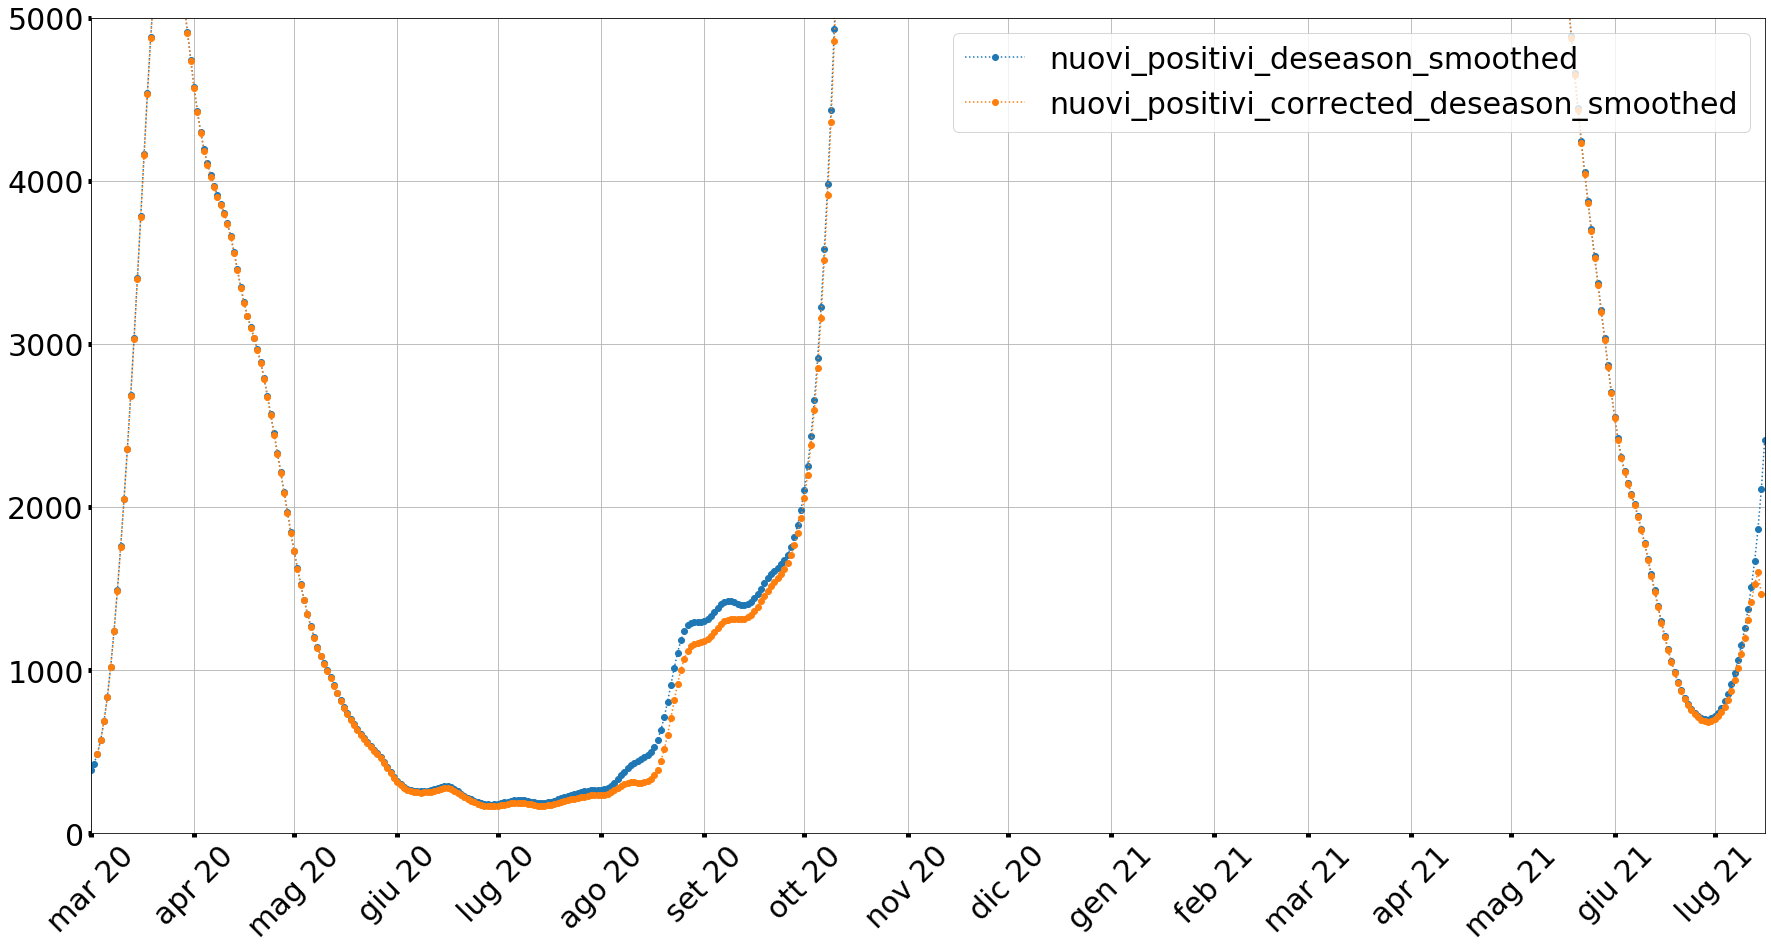

In [32]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_corrected_deseason_smoothed',
        ],
    }],
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    ylim=(0,5000),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

In [33]:
DPC_data['nuovi_positivi_corrected_deseason_smoothed_Rt'] = naive.compute_Rt(
    DPC_data.nuovi_positivi_corrected_deseason_smoothed.fillna(0), alpha=alpha, beta=beta,
    imported_series = DPC_data.imported_ratio_deseason_smoothed_shifted.fillna(0)*DPC_data.nuovi_positivi_deseason_smoothed.fillna(0)
).fillna(0)

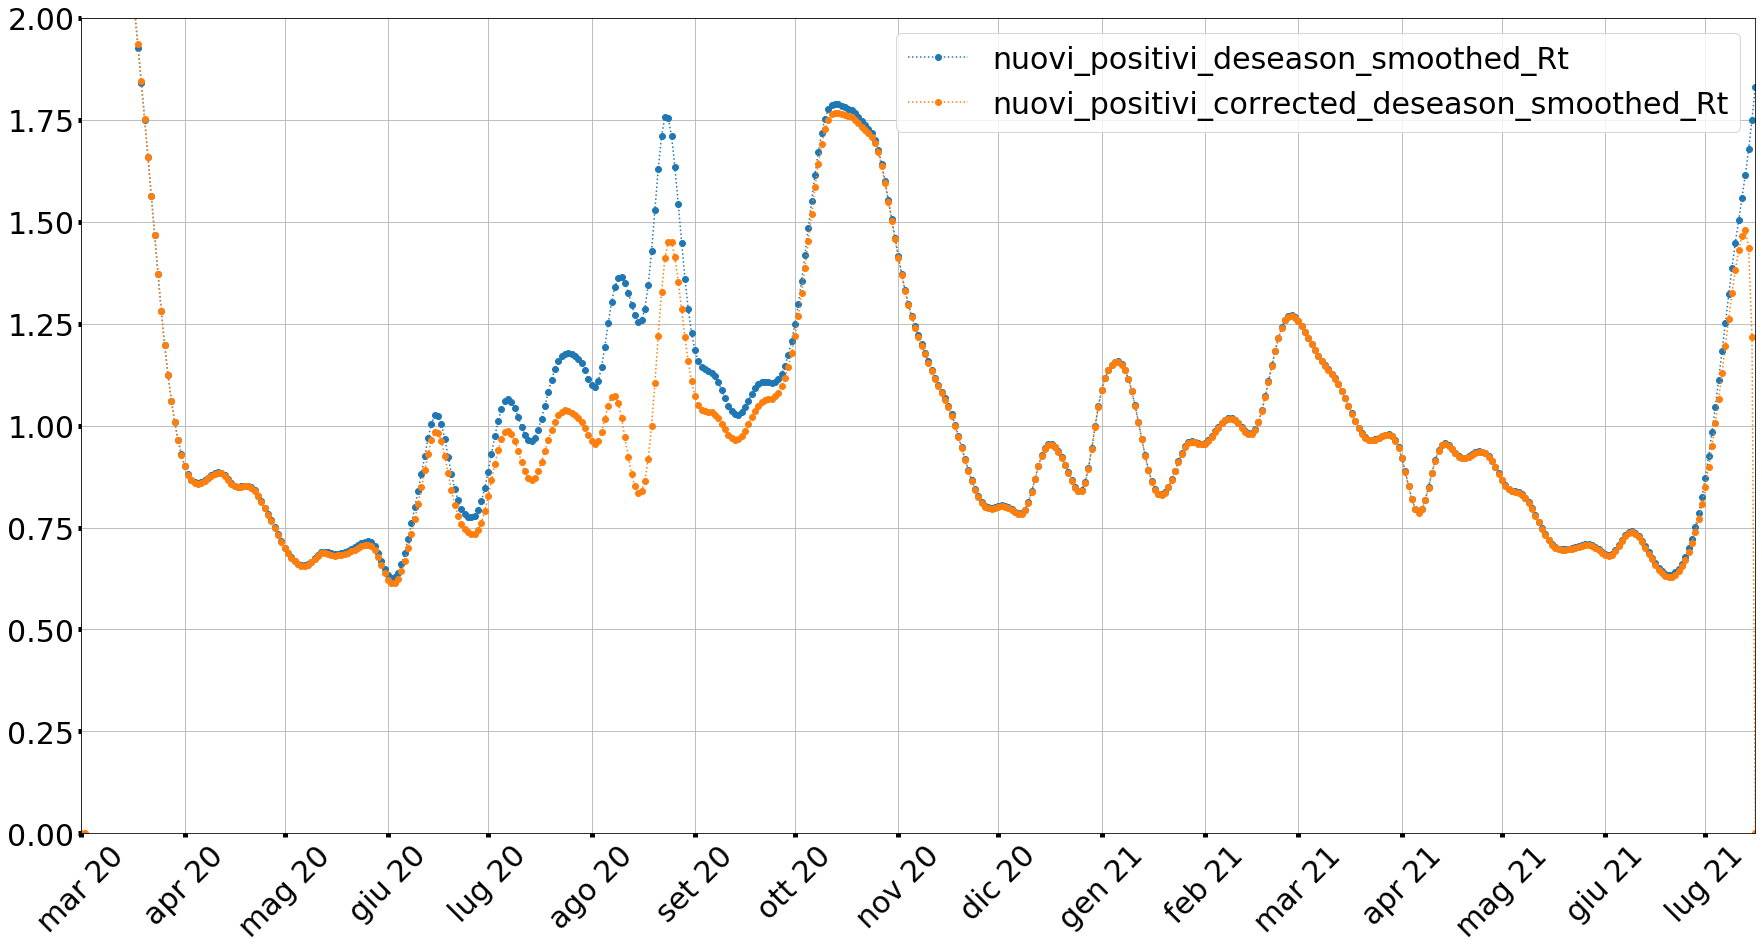

In [34]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            'nuovi_positivi_deseason_smoothed_Rt',
            'nuovi_positivi_corrected_deseason_smoothed_Rt',
        ],
    }],
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    ylim=(0.,2.),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

In [35]:
ISS_Rt = ISS.read_weekly_Rt_from_local()
ISS_Rt_clean = ISS.preprocess(ISS_Rt)
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
43,2021-05-19,2021-06-01,0.68,0.67,0.69,0.01,0.01,2021-05-25 23:59:00
44,2021-05-26,2021-06-08,0.69,0.68,0.73,0.04,0.01,2021-06-01 23:59:00
45,2021-06-01,2021-06-15,0.69,0.62,0.74,0.05,0.07,2021-06-08 23:59:00
46,2021-06-09,2021-06-22,0.63,0.61,0.71,0.08,0.02,2021-06-15 23:59:00
47,2021-06-16,2021-06-29,0.66,0.62,0.85,0.19,0.04,2021-06-22 23:59:00


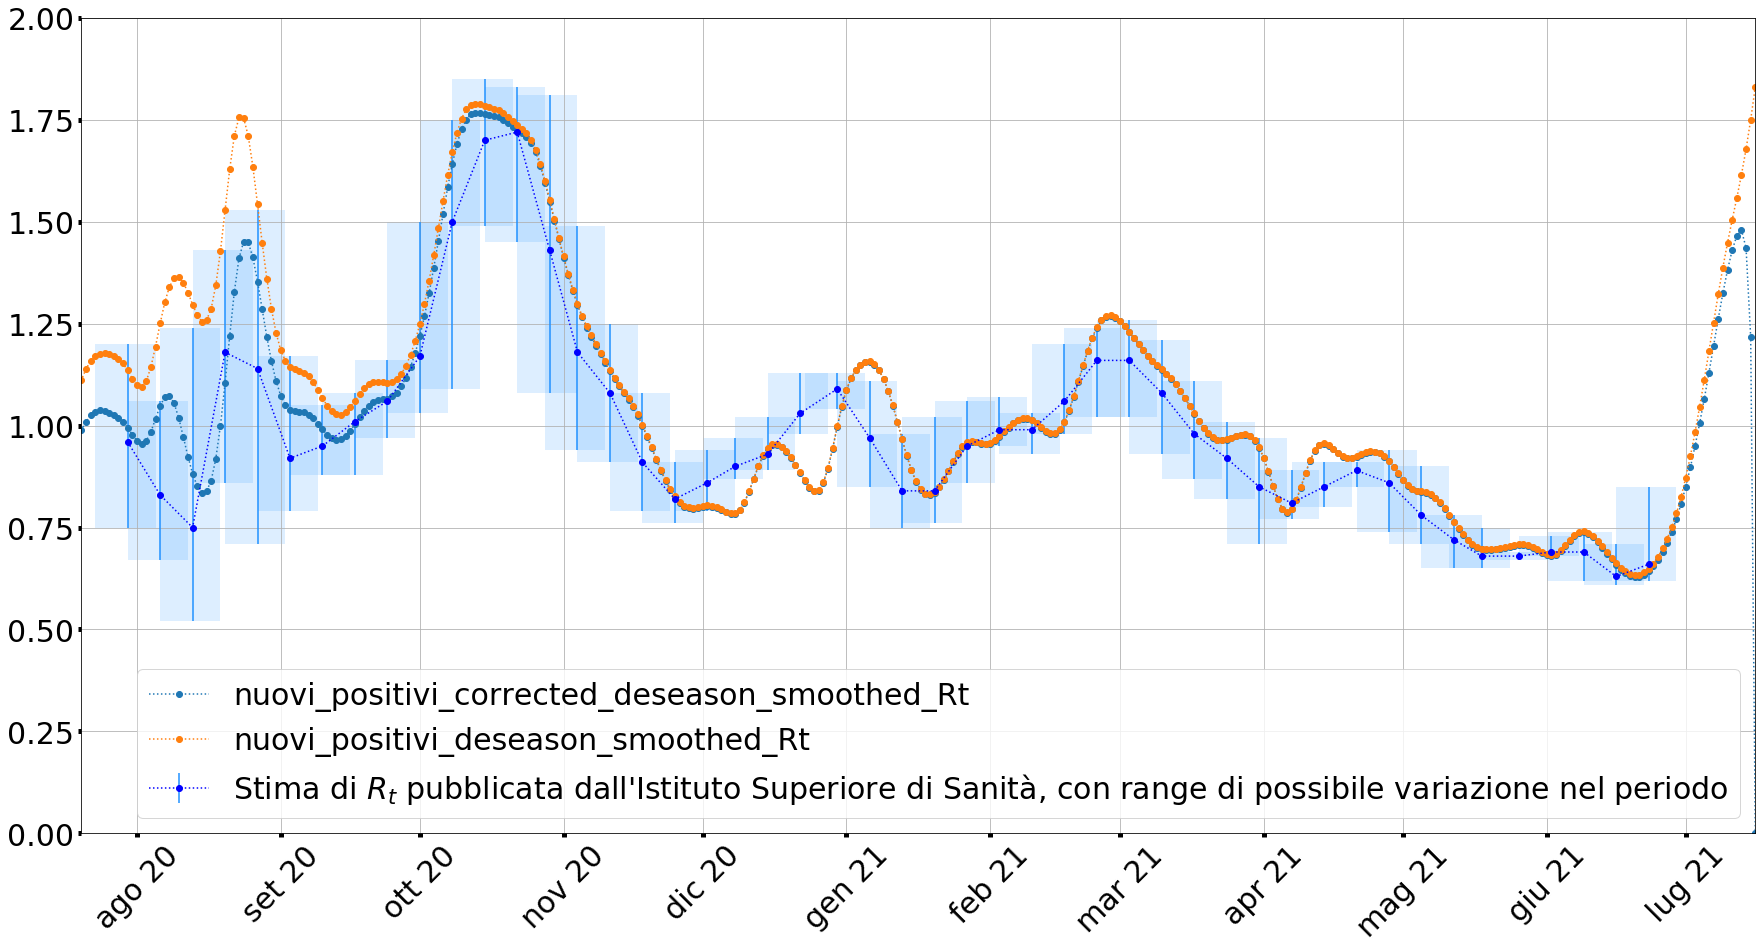

In [37]:
plotting.plot_series(
    data=[
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        },        
        {
            'df': DPC_data,
            'xfield': 'data',
            'yfields': [
                'nuovi_positivi_corrected_deseason_smoothed_Rt', 
                'nuovi_positivi_deseason_smoothed_Rt', 
            ],            
        },
        
    ],
    xlim=(datetime(2020,7,20), DPC_data.data.max()),
    ylim=(0.,2.),
    legend_loc="lower right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)


In [ ]:
local_imported.tail(10)

In [ ]:
DPC_data.nuovi_positivi_corrected